# Node Representation Learning in Graph Neural Networks

In this notebook, the final goal is to predict the class of a node embedded in a graph. To highlight the importance of contextual information to object classification, we compare the performance of a traditional multi-layer perceptron and a Graph Convolutional Network (GCN).

In this first tutorial on Graph Neural Networks (GNN), we introduce the basics of PyTorch Geometric, a.k.a. `PyG`, a `PyTorch` extension which contains:
1. A handy Data structure for storing and processing graph-type data
2. Common benchmark graph datasets
3. Methods for batching multiple graphs for fast computations
4. Graph data tranforms
5. Common GNN implementations

### Goals
- Familiarize yourself with `PyG` data structure
- Learn about ways of drawing graph representastions with `networkx`
- Learn about the open graph datasets provided through `PyG` 
- Understand how to implement, train and use a GNN in `PyG`

## 1. Data Handling, Loading

A graph, as used in GNNs minimally consists of
- A list node features (numerical characteristics of the objects)
- A connectivity matrix, A, encoding node neighborhoods
  - For un undirected graph, if i and j and neigbors, then A_ij = A_ji = 1, 0 otherwise
  - For a directed graph, if a path exists from i to j, then A_ij = 1 but not necessary A_ji = 1
- A list of node labels, i.e. what we are trying to predict

It should also optionally support:
- A list of edge-specific features

### Graph Data object

PyTorch Geometric proposes a Data structure which contains these attributes:
- `x` is a `(C,N_c)` tensor with `C` the number of nodes and `N_c` the number of features per node
- `edge_index` is a `(E,2)` tensor with `E` the number of edges (sparse representation of the connectivity matrix)
- `y` is a tensor with labels
- `edge_attr` is a `(E,N_e)` tensor with `N_e` the number of edge features

In [1]:
import torch
from torch_geometric.data import Data

x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float32)
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)
print('Data:', data)
print('\nNode features:\n', data.x)
print('\nEdge index:\n', data.edge_index)
print('\nNode labels:\n', data.y)

Data: Data(edge_index=[2, 5], x=[4, 2], y=[4])

Node features:
 tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

Edge index:
 tensor([[0, 1, 2, 0, 3],
        [1, 0, 1, 3, 2]])

Node labels:
 tensor([0., 1., 0., 1.])


### Graph properties

The `PyTorch Geometric` `Data` object is not only a container, but also provides handy functions to characterize a graph:

In [2]:
print('Number of nodes:', data.num_nodes)
print('Number of edges:', data.num_edges)
print('Number of node features', data.num_node_features)
print('Contains isolated nodes:', data.contains_isolated_nodes())
print('Contains self loops:', data.contains_isolated_nodes())
print('Is directed:', data.is_directed()) # False here because all edge have their reciprocal edge available

Number of nodes: 4
Number of edges: 5
Number of node features 2
Contains isolated nodes: False
Contains self loops: False
Is directed: True


It is also important to note that these `Data` objects can easily be transferred to GPU memory as a torch Tensor would:

In [3]:
data = data.to(torch.device('cuda'))

print('Data:', data)
print('\nNode features:\n', data.x)
print('\nEdge index:\n', data.edge_index)
print('\nNode labels:\n', data.y)

Data: Data(edge_index=[2, 5], x=[4, 2], y=[4])

Node features:
 tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]], device='cuda:0')

Edge index:
 tensor([[0, 1, 2, 0, 3],
        [1, 0, 1, 3, 2]], device='cuda:0')

Node labels:
 tensor([0., 1., 0., 1.], device='cuda:0')


### Graph schematic in 2D

A handy way to represent graph data is by using the `networkx` library.

It provides a library to automate the drawing of graphs from a list of nodes and a list of edges.

On top of this, `PyG` provides a handy tool to convert any `Data` object to a `networkx` graph

To draw the graph `G`, call `networkx.draw(G)` (`matplotlib` support allows to use the usual features), optionally with the following parameters:
- `pos`: positions of the nodes in a plane. By default `networkx` arbitrarily places them
- `with_labels`: forces to draw node IDs if labels are not specified excplicitely
- `labels`: node labels in a dictionary of `node_id:node_label` pairs
- `nodelist` and `edgelist`: restrict the nodes to be represented (e.g. select activated edges)
- `node_size`: the graphical size of the nodes (default = 300)
- `node_color`: an array of node colors (e.g. node categories)
- `edge_color`: an array edge colors (e.g. edge strength between 0 and 1)
- `font_size`: node label font size (default = 12)
- `font_color`: node label font color
- `font_weight`: node label font weight (e.g. `'bold'`)

Call `help(networkx.drawing.nx_pylab.draw_networkx)` for more info about the more optional parameters.

In this example:
- We label the nodes with `node_id (node_feature)` 
- We represent the node class as a color (purple for 0, yellow for 1)

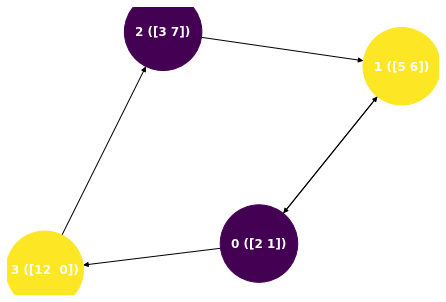

In [4]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

data = data.to(torch.device('cpu')) # networkx does not support GPU, bring data back!
graph = to_networkx(data) # Convert PyG Data into networkx Graph
labels = {i:'{:d} ({})'.format(i,node.int().numpy()) for i, node in enumerate(x)} # Each node is given an ID (value) pair
colors = data.y # Use node labels as color

nx.draw(graph, labels=labels, node_color=colors, node_size=6000, font_weight='bold', font_color='white')

### PyTorch Geometric Dataset

In order to train and test a Graph Neural Network, it is necessary to create a `PyG` `Dataset` to define how to access a graph object and to minimize the time spent on I/O by the algorithm.

To create a `Dataset`, one needs to provide three main components to the class (as for `PyTorch` `Dataset`):
- Constructor, which initializes the `Dataset` attributes
- `__len__` function, which defines the number of entries in the set
- `__getitem__` function, which defines how to get a specific `idx` entry in the dataset

Let us define a dummy dataset, `DummyDataset`, which converts any list of node feature tensors, list of edge tensors and list of node label vectors into a graph object `DataSet`.

In [5]:
import torch
from torch_geometric.data import Data, Dataset

class DummyDataset(Dataset):
    def __init__(self, node_features_v, node_labels_v, edge_index_v):
        # Store the list graph node feature tensors and node label vectors
        self._x = node_features_v
        self._y = node_labels_v
        self._edges = edge_index_v

        # Check the number of entries
        self._entries = len(self._x)


    def __len__(self):
        
        return self._entries

    def __getitem__(self, idx):
        
        # Return node feature tensors and labels
        return Data(x = torch.tensor(self._x[idx], dtype=torch.float32),
                    y = torch.tensor(self._y[idx], dtype=torch.int64),
                    edge_index = torch.tensor(self._edges[idx], dtype=torch.int64),
                    index = [idx])

Now let us define a random set of node features, node labels and edges and initialize the `Dataset` from them.

In [6]:
import numpy as np

# Initialize a list of graph node feature tensors (5 features per node) of 2 to 9 nodes, 1000 times
np.random.seed(123)
node_counts = np.random.randint(2, 10, size=1000)
node_features_v = [np.random.rand(c,5) for c in node_counts]

# Initialize a list of graph node labels between 0 and 3
node_labels_v = [np.random.randint(0,4,size=c) for c in node_counts]

# Initialize a list of 
edge_index_v = [np.vstack(np.where(np.random.choice(2, size=(c,c)))) for c in node_counts]

dataset = DummyDataset(node_features_v, node_labels_v, edge_index_v)
print('Number of events in dataset:', len(dataset))
print(dataset[0])

Number of events in dataset: 1000
Data(edge_index=[2, 38], index=[1], x=[8, 5], y=[8])


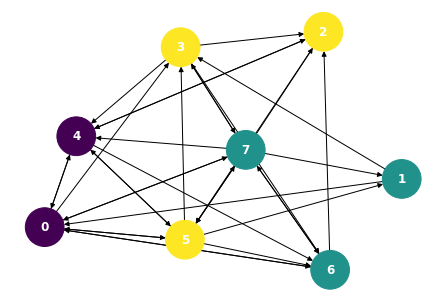

In [7]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

data = dataset[0] # Take the first graph in the dataset
graph = to_networkx(data) # Convert PyG Data into networkx Graph
colors = data.y # Use node labels as color

nx.draw(graph, with_labels=True, node_color=colors, node_size=1500, font_weight='bold', font_color='white')

### DataLoader

Now, use the built-in `DataLoader` provided by `PyTorch Geometric` to define a way to produce batches of the `PyTorch Geometric` `Data` objects, by specifying the providing the following arguments:
- `batch_size`: the number of events to include in the batch
- `shuffle`: whether or not to randomize the choice of subset dataset (if false, simply goes through dataset sequentially)
- `num_workers`: number of parallel data-reader processes to be run (for faster I/O)
- `pin_memory`: speed up data transfer to GPU by avoiding a necessiry to copy data from pageable memory to page-locked (pinned) memory. Read here for more details. If you are not sure about the details, set to True when using GPU

In [8]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset = dataset,
                    shuffle = True,
                    batch_size = 32,
                    num_workers = 1,
                    pin_memory = False)

As any self-respecting data loader, it is iterable!

In [9]:
it = iter(loader)
data = next(it)
data

Batch(batch=[196], edge_index=[2, 703], index=[32], x=[196, 5], y=[196])

In [10]:
data.batch.unique(return_counts = True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 tensor([4, 7, 9, 4, 7, 8, 7, 2, 3, 5, 5, 7, 5, 9, 2, 9, 8, 8, 9, 2, 9, 7, 9, 3,
         8, 5, 8, 8, 2, 8, 6, 3]))

What the batch merge of `Pytorch Geometric` does is the following:
- It adds a new `batch` object which is an array batch ids for each of the node (length `C`)
- It stacks the `x`, `edge_features`, `y` and `index` into single tensors
- It stacks the `edge_index`, relabling the edges coming from different batches to insure that no edge connects two nodes from different entries

This process allows for faster computation than to run the Graph Neural Network on individual entries.

## 2. Open Datasets

When introducing a new GNN framework and testing common architectures, it is useful to have access to common graph-friendly datasets on hand. `PyG` provides common datasets, as `PyTorch` does for other tasks. We will introduce a few common examples in this section.

All the datasets that are made available by `PyG` can be found at [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html):
- Paper referencing dataset for node classification (Cora, Pubmed, Citeseer, etc.)
- Graph classification datasets (ENZYMES, PROTEINS, etc.)
- Point cloud datasets for classification and segmentation tasks (ShapeNet, etc.)

### Cora Dataset

The Cora dataset consists of a single graph in which
- Each node is a scientific paper, characterized by a set of 1433 features, each of which represents the existence of a word in the paper (1 if present, 0 otherwise)
- Each edge is a citation, if a paper i cites j, they are connected by an bidirectional edge ([[i,j],[j,i]])
- The papers are classified in 7 paper categories

This is actually a very common problem that can be found in many contexts:
- Webpage referencing (pages are nodes, hyperlinks are edges, subject is class, e.g. wikipedia)
- Social networking (people are nodes, friendships are edges, age group is class, e.g. facebook)
- Particle classification (particles are nodes, parentage are edges, particle species is class)
- etc.

In [11]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='tmp/Cora', name='Cora')

In [12]:
print('Number of graphs:', len(dataset))
print('Number of node features:', dataset.num_node_features)
print('Number of node classes:', dataset.num_classes)

Number of graphs: 1
Number of node features: 1433
Number of node classes: 7


In [13]:
data = dataset[0]
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [14]:
print('Number of nodes:', data.num_nodes)
print('Number of edges:', data.num_edges)
print('Node classes:', data.y, data.y.shape)

Number of nodes: 2708
Number of edges: 10556
Node classes: tensor([3, 4, 4,  ..., 3, 3, 3]) torch.Size([2708])


In [15]:
data.y.unique(return_counts=True) # Number of nodes in each of the 7 paper categories

(tensor([0, 1, 2, 3, 4, 5, 6]), tensor([351, 217, 418, 818, 426, 298, 180]))

We now would like to represent the dataset. As there are a lot of nodes, simply randomly placing the nodes a canvas and drawing the edges results in something that is not very informative...

Thankfully, the `networkx` package provides another drawing option, `networkx.draw_kamada_kawai`, which is an implementation of the Kamada-Kawai algorithm for **force-directed graph** optimization. The basic concept of this type of representation is to build a physical system, which can be optimized, in which:
- Edges act as springs, constraining nodes that are connected to each other to be at a constant distance
- Nodes repel each, which forces nodes to stay as far as possible from each other

This results in a graph in which nodes with local connectivity to stay close to each other:

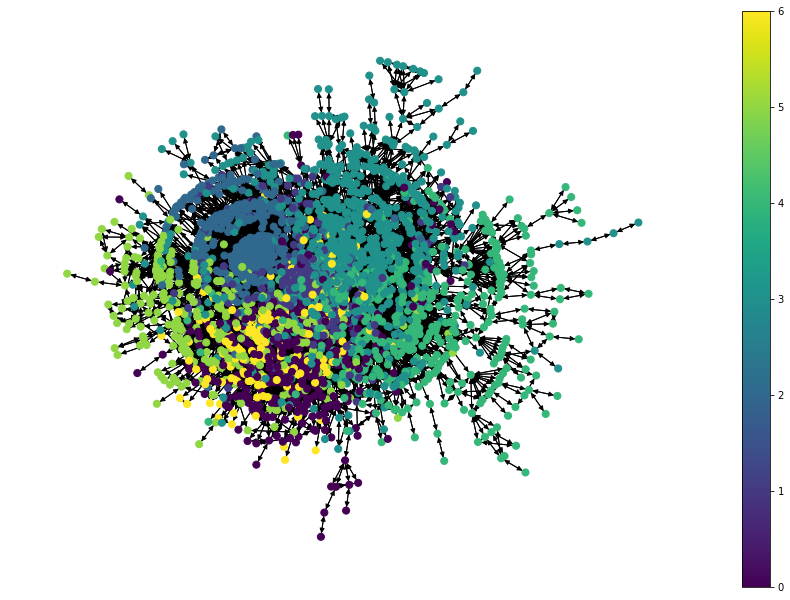

In [16]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.utils.convert import to_networkx

graph = to_networkx(data) # Convert PyG Data into networkx Graph
colors = data.y # Use node labels as color

fig = plt.figure(figsize=(12,8))
cmap = plt.cm.viridis
nx.draw_kamada_kawai(graph, node_color=colors, cmap=cmap, node_size=50)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=6))
sm._A = []
plt.colorbar(sm)
plt.draw()

Right of the bat, we can see that connectivity is going to be crucial in determining the paper category, as some of the catgeories are clearly to be clustered around seperate local connectivity groups.

## 3. Classification with an MLP

Here the goal is to try to classify papers into different categories using a simple Multi-Layer Perceptron. With this strategy, one can simply take the set of node features and try to classify it into one of the 7 paper categories, without any contextual information.


### Tranform dataset to read nodes one at a time

First, we need to define a daset that reads node features one at a time. As usual, we need three ingredients to define a `PyTorch` `Dataset`: an `__init__`, a `__len__` and a `__getitem__`

In [17]:
import torch
from torch_geometric.datasets import Planetoid
from torch.utils.data import Dataset

class CoraNodeDataset(Dataset):
    """
    class: an interface to extract features of single nodes in the Cora dataset
    """
    def __init__(self, task='train'):
        """
        Args: file_path ..... path to the HDF5 file that contains the feature data
        """
        # Load file, store pointer to the node and edge features datasets
        dataset = Planetoid(root='tmp/Cora', name='Cora')
        data = dataset[0]
        if task == 'train':
            self._data = data.x[:2000]
            self._labels = data.y[:2000]
        elif task == 'val':
            self._data = data.x[2000:2300]
            self._labels = data.y[2000:2300]
        elif task == 'test':
            self._data = data.x[2300:]
            self._labels = data.y[2300:]
        else:
            raise KeyError('task must be one of: train, val, test')

        # Check the number of entries
        self._entries = len(self._data)


    def __len__(self):
        
        return self._entries

    def __getitem__(self, idx):
        
        return self._data[idx], self._labels[idx]


In [18]:
dataset = CoraNodeDataset(task='train')
print('Number of events in the training set:', len(dataset))
dataset[0] # This paper belong to the fourth category

Number of events in the training set: 2000


(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(3))

In [19]:
dataset[0][0].unique(return_counts=True) # 9 tracked words have been found in paper 0

(tensor([0., 1.]), tensor([1424,    9]))

### Define the MLP

Then, we need to define an MLP which take 1433 features as an input, and reduces them to 7.

We define a very basic MLP with a single hidden layer, a LeakyReLU activation and a dropout layer to reduce overfitting.

In [20]:
import torch.nn as nn
import torch.functional as F

class MLP(nn.Module):
    
    def __init__(self, num_filters):
        
        super(MLP, self).__init__()
        # MLP with one hidden layers of num_filters neurones
        self._classifier = nn.Sequential(
            nn.Linear(1433, num_filters), 
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(num_filters, 7)
        )

    def forward(self, x):
        # Make 2d image into 1D array
        return self._classifier(x)

In [21]:
model = MLP(num_filters=16)
model

MLP(
  (_classifier): Sequential(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=7, bias=True)
  )
)

### Train the MLP

Here we define a function which 
1. loops over the data
2. passes each bach through the model
3. computes the loss
4. Optimize the weights at each step

In [22]:
import numpy as np
import torch

def train_torch(loader, model, num_iterations=100, lr=0.01, optimizer='Adam', weight_decay=5e-4):
    
    # Create a Cross-Entropy (CE) loss module
    criterion = torch.nn.CrossEntropyLoss()
    
    # Create an optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(),lr=lr,weight_decay=weight_decay)
    
    # Now we run the training!
    loss_v=[]
    while num_iterations > 0:
        for data, label in loader:
            # Prediction
            prediction = model(data)
            
            # Compute loss
            loss = criterion(prediction, label)
            
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record loss
            loss_v.append(loss.item())
            
            # Brake if above the maximum number of iterations
            num_iterations -= 1
            if num_iterations < 1:
                break
        
    return np.array(loss_v)

Now run 2000 iterations of the training set (200k randomly sampled nodes (200 epochs) in 2000 batches of size 100).

In [23]:
from torch.utils.data import DataLoader
torch.manual_seed(123) # Make sure we all get the same results

# Initialize the loader with the CoraNodeDataset training set
loader = torch.utils.data.DataLoader(CoraNodeDataset(task='train'),
                                     batch_size=100,
                                     shuffle=True,
                                     num_workers=1,
                                     pin_memory=False)

# Reinitialize the MLP (random weighs)
model = MLP(num_filters=16)

# Train the model for 1000 iterations
losses = train_torch(loader, model, 2000)

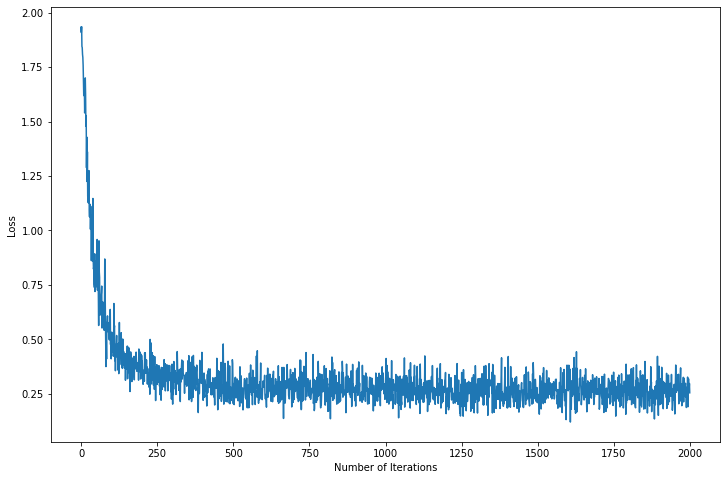

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.draw()

### Test the trained network on the test set

Define a function which checks the output of the network and compares it to the labels.

Simply reuse the data loader

In [25]:
loader = torch.utils.data.DataLoader(CoraNodeDataset(task='test'),
                                     batch_size=32,
                                     shuffle=False,
                                     num_workers=1,
                                     pin_memory=False)

In [26]:
import numpy as np
from scipy.special import softmax

def test_torch(loader, model):

    pred_v   = []
    softmax_v = []
    label_v = []
    
    model.eval() # Sets Dropout in evaluation mode (does not drop out)
    with torch.set_grad_enabled(False):
        idx = 0
        for data, label in loader:
            prediction = model(data).numpy()
            
            pred_v.append(    np.argmax(prediction, axis=1) )
            softmax_v.append( softmax(prediction, axis=1)   )
            label_v.append( label )
            
            idx +=1
            
    return np.concatenate(pred_v), np.vstack(softmax_v), np.concatenate(label_v)

In [27]:
pred, scores, label = test_torch(loader, model)

In [28]:
print('Accuracy:', np.sum(pred==label)/len(pred))

Accuracy: 0.7622549019607843


### Correlation among classification target types

Without into details, I prepared 2 functions:
- `draw_confusion_matrix` creates a classification output matrix that shows the true label type v.s. predicted type with the number of images filling the matrix cells.
- `draw_softmax_scores` shows the correlation of softmax score across different digits for each image. You see a decagon with digit types on each edge with lots of dots inside. Each dot represent the softmax score of one image. The location of a dot is determined by interpreting the softmax score as a position vector from the origin. If the score is completley uncertain (i.e. 0.1 for each type), this would put a point in the middle. If it is 100% a certain digit type, the dot will be on the correponding edge of the decagon.

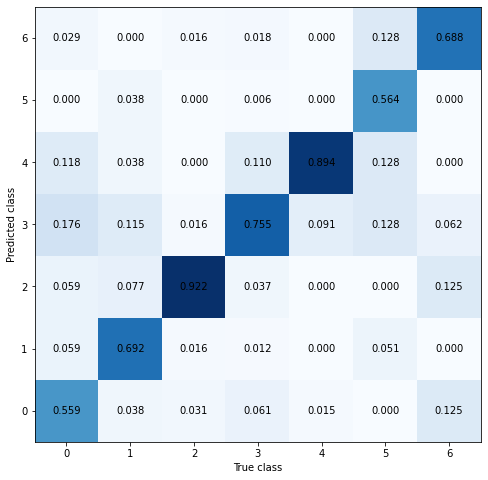

In [29]:
# Draw the confusion matrix
from notebook_utils import plot_confusion_matrix

plot_confusion_matrix(label, pred, normalize=True)

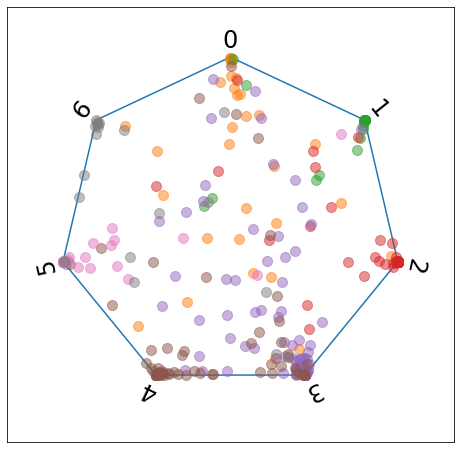

In [30]:
# Draw the softmax scores
from notebook_utils import plot_softmax

plot_softmax(label, scores)

### 3. Graph Convolutional Networks

As described in more detail in the lecture, GCN are a substitute to CNNs when the data does not present itself as a locally dense image. It generalizes the local neighborhood receptive field of CNNs to any graph neighborhood defines on a set of objects (nodes). In the same way that CNNs encode image pixels into a new set of features, GCNs tranform graph node features into a new representation.


### Dataset

The Graph Neural Network processes the entire dataset as single graph but only penalizes the model weights on a subset of the nodes (the training nodes), and validates and test them on other sets. Here we simply define masks that define the boundaries of those subsets for future use.

In [31]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
n_nodes = len(dataset[0].x)

import numpy as np
train_mask, val_mask, test_mask = np.zeros(n_nodes, dtype=np.bool), np.zeros(n_nodes, dtype=np.bool), np.zeros(n_nodes, dtype=np.bool)
train_mask[:2000] = True
val_mask[2000:2300] = True
test_mask[2300:] = True

### Graph Convolution Implementation

`PyG` contains an implementation of graph convolutions, but it's interesting to see how to implement it from scratch to understand what `PyG` does:

In [32]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

### Model architecture

Here we employ an architecture that is identical to our earlier MLP, but we replace the the linear layers (connecting all previous features to the next feature layer) by graph convultions, `GCN`. What these do is that, at each update, all the node features in the neighborhood of the node being updated are aggregated, with some learnable weights, and used to update the node embeddings.

In [33]:
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, num_input, num_classes, num_hidden=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_input, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [34]:
model = GCN(num_input=1433, num_classes=7, num_hidden=16)
model

GCN(
  (conv1): GCNConv(
    (lin): Linear(in_features=1433, out_features=16, bias=True)
  )
  (conv2): GCNConv(
    (lin): Linear(in_features=16, out_features=7, bias=True)
  )
)

### Training loop

Define a function which checks the output of the network and compares it to the labels.

Simply reuse the data loader

In [35]:
import numpy as np
import torch

def train_gcn(data, model, train_mask, num_epochs=100, lr=0.01, optimizer='Adam', weight_decay=5e-4):
    
    # Create a Binary-Cross-Entropy (BCE) loss module
    criterion = torch.nn.CrossEntropyLoss()
    
    # Create an optimizer
    optimizer = getattr(torch.optim, optimizer)(model.parameters(),lr=lr, weight_decay=weight_decay)
    
    # Now we run the training!
    loss_v = []
    for _ in range(num_epochs):
        # Prediction
        prediction = model(data)

        # Compute loss
        loss = criterion(prediction[train_mask], data.y[train_mask])

        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss
        loss_v.append(loss.item())
        
    return np.array(loss_v)

In [36]:
from torch_geometric.datasets import Planetoid
torch.manual_seed(1234) # Make sure we all get the same results!

# Dataset initialization
dataset = Planetoid(root='tmp/Cora', name='Cora')
data = dataset[0]

# Model initialization
model = GCN(num_input=1433, num_classes=7, num_hidden=16)

# Train loop
losses = train_gcn(data, model, train_mask, num_epochs=200)

# Save weights for later use !
torch.save(model.state_dict(), 'gcn_weights.w')

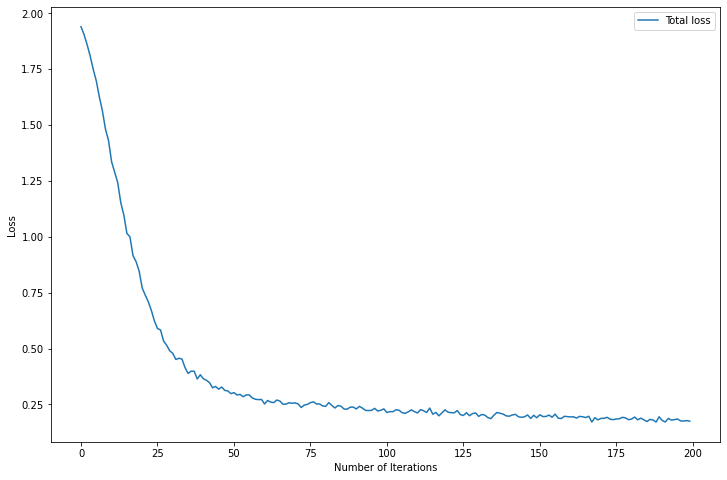

In [37]:
from matplotlib import pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(losses, label='Total loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.draw()

### Test the trained GCN

Try to predict the class of the nodes in the subset of test nodes

In [38]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[test_mask].eq(data.y[test_mask]).sum().item())
acc = correct / len(pred[test_mask])
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8922


This is a significant improvement over a simple MLP, as one would expect!

### Exercise 1

Make the confusion matrix and the softmax score plot on the predictions again, check the results:

In [39]:
# Your code here

### Exercice 2

Implement the same model but with two times the amount of features in the hidden layer. Train again, compare by:
- Computing the node-wise accuracy
- Evaluating the confusion matrix
- Taking a look at the softmax score plot

In [40]:
# Your code here

### Exercise 3

Stop the GCN training when it reaches optimal performance on the validation dataset `CoraNodeDataset(task='val')`

The idea here is to evaluate the accuracy on the validation set every `n` iterations (say 100) and stop the training when the performance on the validation set starts to deteriorate (i.e. the model starts to overfit). This is a form of **early stopping**.

In [41]:
# Your code here

### Exercise 4: Change the type of message passing

Graph Convolution is only one of many ways to aggregate node neighborhood features.

`PyG` provides [many other learnable functions](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) that one could use to update the nodes features. Try to implement another GNN model which replaces the `GCN` layers by `GATConv` layers. Compare the performance.

In [42]:
# Your code here

## 4. Node embedding visualization

To gain some insight as to what the Graph Neural Network is doing, it's is interesting to visualize what happens to the node embeddings when the graph is training. Intuitively, the network should put nodes that belong to separate classes further apart in embedding space.

### New model

Let us first slightly modify the model for it to return intermediate node embeddings:

In [43]:
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, num_input, num_classes, num_hidden=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_input, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x_inter = self.conv1(x, edge_index)
        x = F.relu(x_inter)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x_inter, x

### t-SNE

Now, one cannot visualize embeddings in any n-dimensional space. Instead, we use t-SNE ([t-distributed stochastic neighbor embedding](https://lvdmaaten.github.io/tsne/)), which is used to reduce the number of dimensions of a high-dimensional space by minimizing the KL divergence, i.e. by picking the marginal distribution which is closest -- in statistical terms -- to the full distribution. In other words, it tries to preserve distance between point embeddings: if two points are close in 16 dimension, they should be close in the marginal space.

First, we take a look at the embeddings of the data (the input 1433 node features):

In [44]:
from sklearn.manifold import TSNE

embeddings = dataset[0].x.numpy()
embeddings = TSNE(n_components=2).fit_transform(embeddings)

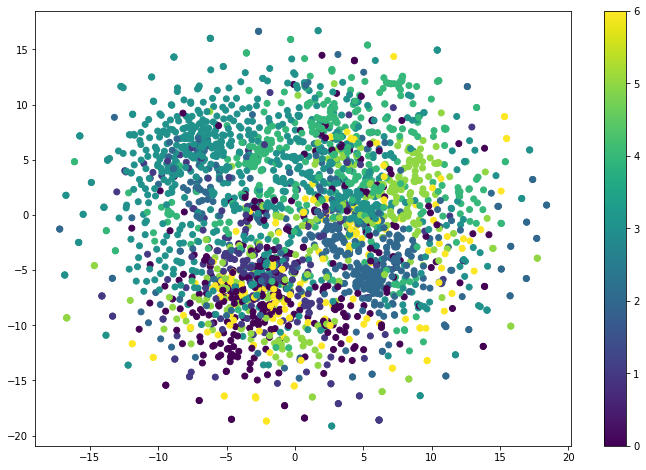

In [45]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c=dataset[0].y.numpy())
plt.colorbar()

There is a lot of overlap and no obvious clusters.

Now we pass it through a randomly initialized GNN:

In [46]:
model = GCN(num_input=1433, num_classes=7, num_hidden=16)
model.eval()

embeddings = model(dataset[0])[0].detach().numpy()
embeddings = TSNE(n_components=2).fit_transform(embeddings)

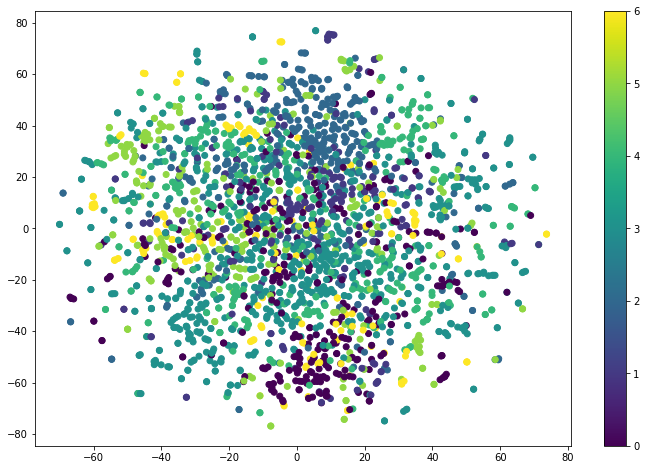

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c=dataset[0].y.numpy())
plt.colorbar()

As you can see, the embeddings on an untrained network are completely random. Now let's load up the weights for the network we trained previously and check again:

In [48]:
model.load_state_dict(torch.load('gcn_weights.w'))
model.eval()

GCN(
  (conv1): GCNConv(
    (lin): Linear(in_features=1433, out_features=16, bias=True)
  )
  (conv2): GCNConv(
    (lin): Linear(in_features=16, out_features=7, bias=True)
  )
)

In [49]:
embeddings = model(dataset[0])[0].detach().numpy()
embeddings = TSNE(n_components=2).fit_transform(embeddings)

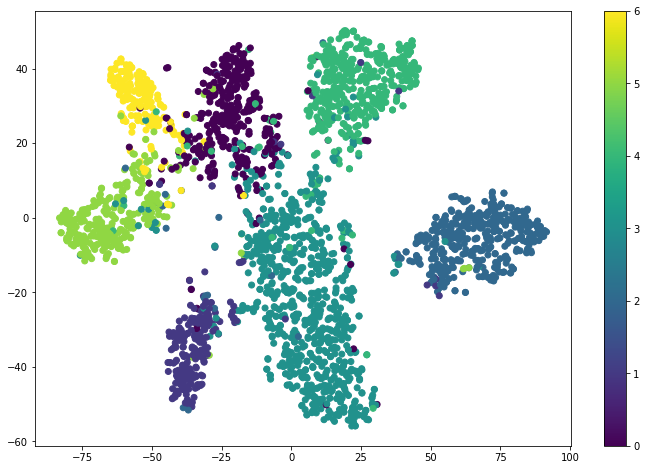

In [50]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embeddings[:,0], embeddings[:,1], c=dataset[0].y.numpy())
plt.colorbar()

Much better indeed!